In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

from tqdm import tqdm
from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl

2025-12-06


!!!! do prepare configs, run shell script. before run this script of AUPRC 

In [3]:
workdir = '/mnt/disk7t/xwj/axolotl_rev'
os.system(f'mkdir -p {workdir}/result/table')
os.system(f'mkdir -p {workdir}/result/figure')
os.system(f'mkdir -p {workdir}/result/gtex_processed')

# level 1
output_path = f'{workdir}/result/dataset_gtex_nmd'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

tissues = pd.read_csv(f'{workdir}/gtex_processed/tissues.tsv', sep='\t', index_col=0)

In [24]:
def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]

def pred_outlier_auprc(df_pred, df_outlier):
    
    df_pred.index.name = 'Gene'
    df_pred.columns.name = 'Sample'
    pr_curve = df_pred.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    pr_curve = pr_curve.sort_values(by='pred',ascending=True)
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['rank'] = range(1,pr_curve.shape[0]+1,1)
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1,num=n_seg+1)

In [30]:
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

phase = "_valid"
baselines = [ 'OUTRIDER_padjust' ]
num = 49

print(num, phase, recall_seg, baselines)

49 _valid [0.    0.001 0.002 ... 0.998 0.999 1.   ] ['OUTRIDER_padjust']


In [29]:
n_start = 3
n_end = 10
mymethods = [ i for i in range(n_start,n_end)]
simu = 0
for i, row in tissues.iterrows():
    
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    # --> level 2. (tissue, task) one tissue have many tasks
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    # 读入任务
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
    # validation phase is optimize the AXO model
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t', index_col=0)
    print(prefix, samples.shape, outliers_used.shape) 
 
    for j,row in task_config.iterrows():
        # 'OUTRIDER'
        dict_auprc = dict()
        dict_curve = dict()
        m = 'OUTRIDER_padjust' # 
        method, score = m.split('_',1)
        print(method, score)
        df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0, compression='gzip')
        df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
        class_col = 'aberrant'
        dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)        

        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method   
        outputdata = [ t, tn, i, dict_auprc, dict_curve ]
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )
    break
    # 获取样本总数, 计算 dim_q0 的值
    Nsample = ns
    dim_q0_values = [int(Nsample / q) for q in range(n_start, n_end)]  # 1/4 到 1/7 的整数值
    # dim_q0_values = sorted(set(dim_q0_values))
    print("dim_q0_values:", dim_q0_values)
    continue 
    # 遍历每个dim_q0 , process precomputed OUTRIDER result
    for (m, dim_q0) in zip(mymethods, dim_q0_values):  
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        # OUTRIDER 输出路径
        outscore = task_config.loc[simu, 'OUTRIDER']
        outscore_with_dim = f'{outscore}_dim{dim_q0}.gz'
        if os.path.exists(outscore_with_dim):
            # print(prefix, m, dim_q0, samples.shape,outliers_used.shape)
            print(f'Running OUTRIDER with dim_q0 = {dim_q0}')
            j = simu # 
            dict_res[j] = pd.read_csv(outscore_with_dim, sep='\t', index_col=0)
            
            df_pred = dict_res[j].copy()
            if 'Sample' in outliers_used.columns:
                df_outlier = outliers_used[outliers_used['Sample'].isin(df_pred.columns)]
            else:
                outlier_sample_col = 'SAMPLE_ID'
                outlier_gene_col = 'Gene'
                df_outlier = outliers_used[outliers_used[outlier_sample_col].isin(df_pred.columns)]\
                    .rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
            # 调用函数auprc
            dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
        
        if False:
            file = f'{metric_output_path}/{prefix}_{m}_outriderdim_auprc{phase}.pkl' # one tissue One method   
            outputdata = [ t, tn, i, dict_auprc, dict_curve ]
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )
    break

t00_ADPSBQ_s648_g13675 (1, 648) (892, 8)
OUTRIDER padjust


In [47]:
draw_methods = mymethods + baselines
# fig, axes = plt.subplots(1, tissues.index.max()+2, figsize=(40, 5))
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

dict_curve,dict_auprc = dict(),dict()
all_curves = []
for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE 
    
    #---------
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    for m in baselines:
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc[k][m], dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
           
    for m in mymethods:
        
        file = f'{metric_output_path}/{prefix}_{m}_outriderdim_auprc{phase}.pkl' # one tissue One method  
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc[k][m], dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]

    required_sets = 1
    draw = \
    pd.concat( [ 
        pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                axis=0, keys= range(required_sets)).reset_index(drop=True)
        for m in draw_methods ], axis=0, keys=draw_methods)\
    .reset_index()
    
    # 添加组织信息
    draw['tissue'] = t
    all_curves.append(draw)
    auprc.loc[i,:] = [dict_auprc['all'][m][0] for m in draw_methods]

# 合并所有组织的数据
all_curves = pd.concat(all_curves)
all_curves.shape

(392392, 8)

In [48]:
print(phase)
draw_methods = baselines + mymethods

# 绘制带置信区间的PR曲线
all_curves['recall_percent'] = all_curves['recall'].round(3)
long_name = { m:f'OUTRIDER(dim=N/{m})' for m in mymethods }
long_name['OUTRIDER_padjust'] = "OUTRIDER(default)"
all_curves['Method'] = all_curves['level_0'].map(long_name)

auprc.columns = auprc.columns.map(long_name)
auprc.head()

_valid


,OUTRIDER(dim=N/3),OUTRIDER(dim=N/4),OUTRIDER(dim=N/5),OUTRIDER(dim=N/6),OUTRIDER(dim=N/7),OUTRIDER(dim=N/8),OUTRIDER(dim=N/9),OUTRIDER(default)
0,0.003259,0.002904,0.002366,0.002004,0.001688,0.001401,0.001205,0.001987
1,0.002776,0.002246,0.002062,0.001637,0.001403,0.001211,0.001074,0.001693
2,0.003676,0.002451,0.001523,0.001109,0.000842,0.000627,0.000448,0.001138
3,0.005801,0.00499,0.004046,0.003384,0.00274,0.002452,0.002074,0.003423
4,0.000679,0.000475,0.000321,0.000253,0.00023,0.00021,0.000167,0.000274


[('OUTRIDER(dim=N/3)', 'OUTRIDER(default)'), ('OUTRIDER(dim=N/3)', 'OUTRIDER(dim=N/4)')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OUTRIDER(dim=N/3) vs. OUTRIDER(dim=N/4): Wilcoxon test (paired samples), P_val:2.346e-11 Stat=3.800e+01
OUTRIDER(dim=N/3) vs. OUTRIDER(default): Wilcoxon test (paired samples), P_val:1.066e-14 Stat=2.000e+00


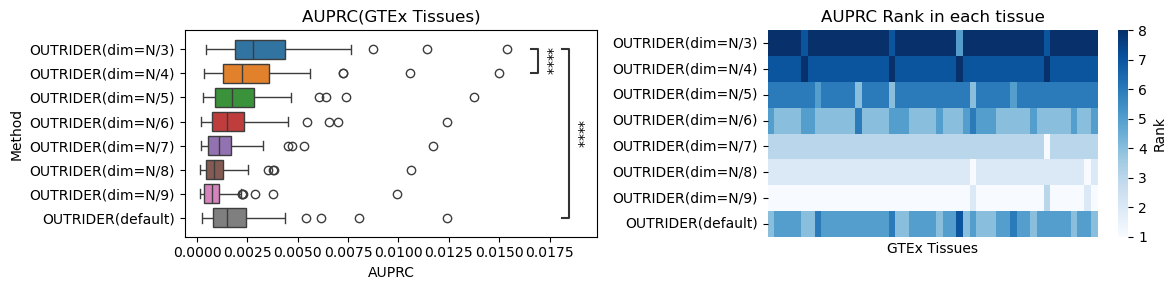

In [59]:
plt.style.use('default')

fig, axes = plt.subplots(1,2, figsize=(12, 3), sharey=False, )
auprc_long = auprc.astype(np.float32).stack().reset_index(name='AUPRC').rename(columns={'level_1':'Method', 'level_0':'Tissue'})
sns.boxplot( auprc_long,  x = 'AUPRC', y='Method', orient='h', hue='Method', ax=axes[0],)
# axes[0].set_xscale('log')
# ticks = [ 0.001, 0.005, 0.01, 0.02, 0.03, 0.05]
# axes[1].set_xticks(ticks)
# axes[1].set_xticklabels([str(t) for t in ticks])
axes[0].set_xlabel('AUPRC')
axes[0].set_title('AUPRC(GTEx Tissues)')

import itertools
pairs = [('OUTRIDER(dim=N/3)', 'OUTRIDER(default)'), ('OUTRIDER(dim=N/3)', 'OUTRIDER(dim=N/4)')]
print(pairs)
# pairs=[("f20L", "f23L"),("f21L", "f23L"),("f22L", "f23L")]
annotator = Annotator(axes[0], pairs, data=auprc_long,   x = 'AUPRC', y='Method',orient='h' )
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()


# （3） ascending 
auprc_rank = auprc.rank(axis=1, method='min')
sns.heatmap(
    auprc_rank.T,  # 原始值作为注释
    annot=False,  # 显示数值
    fmt='.3f',  # 数值格式
    cmap='Blues',  # 使用蓝色渐变
    cbar_kws={'label': 'Rank'},  # 色条标签
    linecolor=None, linewidths=0.05,
    xticklabels=False,
    yticklabels=True,
    ax=axes[1],
)

axes[1].set_title('AUPRC Rank in each tissue')
axes[1].set_xlabel('GTEx Tissues')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_box_outrider_dim_range.pdf', dpi=200)

In [60]:
# p-value
auprc = auprc.astype(np.float32)

from scipy.stats import wilcoxon
import itertools

columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

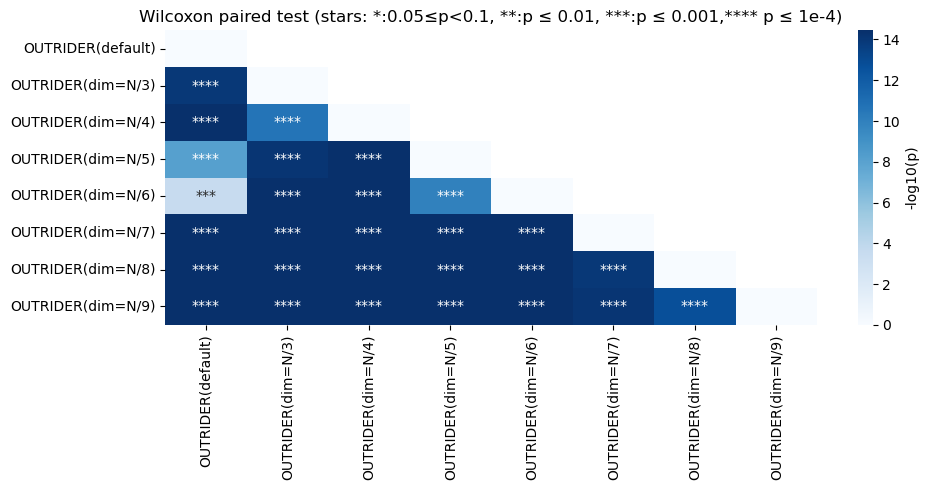

In [65]:
axo_results = results#.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
# ---- 1. 对称矩阵化 ----
pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
pivot = pivot.combine_first(pivot.T)        # 补全下三角
np.fill_diagonal(pivot.values, 1)           # 对角=1
# pivot = pivot.loc[mymethods, mymethods]
# ---- 2. -log10 变换 ----
log_p = -np.log10(pivot)
log_p = log_p.replace([np.inf, -np.inf], np.nan)

# ---- 3. 三角掩码 ----
mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

def p2star(p):
    if pd.isna(p) or p > 0.05:
        return ''
    elif p <= 1e-4:
        return '****'
    elif p <= 1e-3:
        return '***'
    elif p <= 1e-2:
        return '**'
    else:
        return '*'

# 1. 星号对称矩阵（同索引）
star_mat = pivot.applymap(p2star)

# ---- 4. 画图 ----
plt.figure(figsize=(10, 5))
sns.heatmap(log_p,
            mask=mask,
            cmap='Blues',
            annot=star_mat,
            fmt='',
            cbar_kws={'label': '-log10(p)'})
plt.title('Wilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001,**** p ≤ 1e-4)')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/gtex_valid_auprc_wilcox_p_star_outrider_dim_range.pdf', dpi=200)
